#### Includes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import altair as alt
from altair import datum
import time
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 5)

In [3]:
from sources import load_dataset, parse_config, setup_model
from steered_cnn.utils.rotequivariance_toolbox import *
from steered_cnn.steered_conv.steerable_filters import radial_steerable_filter, plot_filter
from steered_cnn.utils import clip_pad_center
from steered_cnn.steered_conv import SteerableKernelBase
from steered_cnn.models import SteeredHemelingNet, HemelingNet
from src.trainer import BinaryClassifierNet

## Consistency Check

#### Weigth Approximation

In [4]:
base = SteerableKernelBase.create_from_rk(4)
x = torch.linspace(-2,2,5)
x,y = torch.meshgrid(x,x)
K = (x+y)/4
K = K.reshape(1,1,5,5)
K = clip_pad_center(K, base.base.shape)

info = {}
W = base.approximate_weights(K, info)

Approximation Metric: mse=0.002, r2=0.987


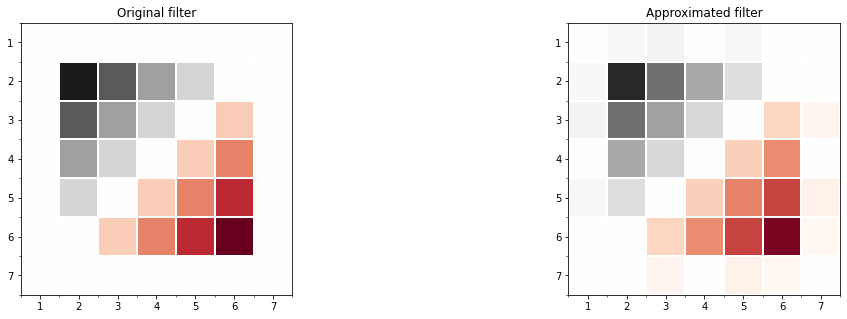

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2)
plot_filter(K[0,0], plot=ax1, vmax=1)
ax1.set_title('Original filter')
plot_filter(info['y_approx'][0,0], plot=ax2, vmax=1)
ax2.set_title('Approximated filter')
print(f'Approximation Metric: mse={info["mse"]:.3f}, r2={info["r2"]:.3f}')

#### Steerability Test

**Composite Kernels**

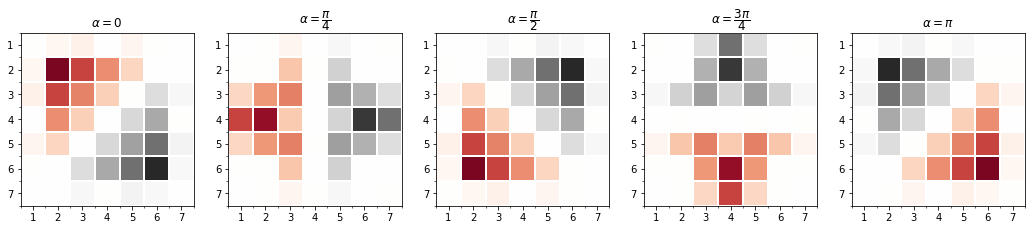

In [6]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,5)
N = len(axs)-1
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.composite_kernels_conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')

**Preconvolved Kernels**

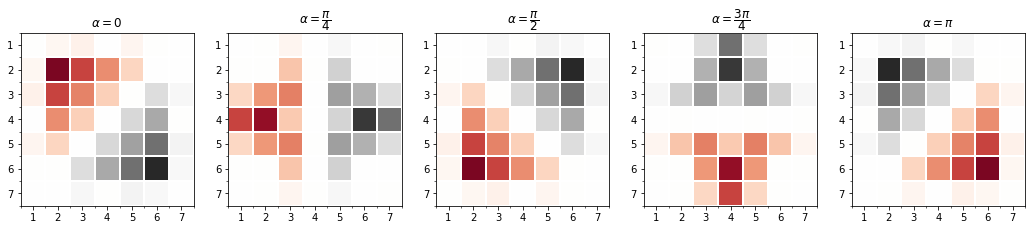

In [7]:
I = torch.zeros((1,1,7,7))
I[:,:,3,3] = 1
fig, axs = plt.subplots(1,5)
N = len(axs)-1
alphas = np.linspace(0, np.pi, N+1, endpoint=True)
for i in range(N+1):
    plot_filter(base.preconvolved_base_conv2d(I,W, alpha=alphas[i])[0,0], plot=axs[i], vmax=1)
    axs[i].set_title(f'$\\alpha = {repr_pi_fraction(i,N)}$')

## Speed Test

**Single Layer**

In [16]:
def speed_test(X=200, R=4, K=5, n_in=10, n_out=10, batch=8, repetitions=10):
    base = SteerableKernelBase.create_from_rk(R, max_k=K)
    x = torch.rand((batch, n_in, X, X)).cuda()
    W = torch.nn.Parameter(base.create_weights(n_in, n_out)).cuda()
    base.conv2d(x,W,alpha=.5)
    
    tf_comp, tf_pre = 0, 0
    tb_comp, tb_pre = 0, 0
    for i in range(repetitions):
        x = torch.rand((batch, n_in, X, X), requires_grad=True).cuda()
        
        t0 = time.perf_counter()
        y = base.composite_kernels_conv2d(x,W,alpha=.5)
        t1 = time.perf_counter()
        tf_comp += t1-t0
        
        y=y.sum()
        t0 = time.perf_counter()
        y.backward()
        t1 = time.perf_counter()
        tb_comp += t1-t0
        
        t0 = time.perf_counter()
        y = base.preconvolved_base_conv2d(x,W,alpha=.5)
        t1 = time.perf_counter()
        tf_pre += t1-t0
        
        y=y.sum()
        t0 = time.perf_counter()
        y.backward()
        t1 = time.perf_counter()
        tb_pre += t1-t0
        
    return tf_comp, tf_pre, tb_comp, tb_pre

speed_test(X=32, n_in=64, n_out=64)

(0.06379954700059898,
 0.05927366399737366,
 0.24762157300028775,
 0.23409041200102365)

**Whole Network**

In [6]:
net = SteeredHemelingNet(6,1).cuda()

t0 = time.perf_counter()
x = torch.rand((2, 6, 512, 512)).cuda()
alpha = .5*torch.ones((2,2,512,512)).cuda()
y = net(x,alpha=alpha)
t1 = time.perf_counter()
tf = t1-t0

y=y.sum()
t0 = time.perf_counter()
y.backward()
t1 = time.perf_counter()
tb = t1-t0

In [7]:
print(f'Composite | Forward: {tf:.3f}s, Backward: {tb:.3f}s')

Composite | Forward: 0.121s, Backward: 0.853s


In [5]:
print(f'Preconvolved | Forward: {tf:.3f}s, Backward: {tb:.3f}s')

Preconvolved | Forward: 0.113s, Backward: 1.308s
